<a href="https://colab.research.google.com/github/FKhadivpour/Responsibility_CIFAR10/blob/main/Experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Simple CNN model for CIFAR-10
import numpy as np
import pandas as pd
import os
import keras
from tensorflow.keras.datasets import cifar10, cifar100
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Input
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras import optimizers
from tensorflow.keras import callbacks
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.layers import Convolution2D
from tensorflow.keras.layers import MaxPooling2D, AveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
%matplotlib inline
import pickle
import random
import skimage
from skimage.util import img_as_ubyte
import skimage.transform
import tensorflow as tf

from tensorflow.keras.applications.efficientnet import EfficientNetB0
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

from collections import Counter

In [ ]:
def convert_to_lenet_size(images):
  tmp_images = tf.image.resize(images,(32,32))
  return np.array(tmp_images)
  # return tmp_images

# Load Data
(X_train, y_train),(X_val,y_val) = keras.datasets.mnist.load_data()
# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.166666666, stratify=y, random_state=42)

X_train = convert_to_lenet_size(np.expand_dims(X_train, axis=3))
print("Train Done!")
# X_test = convert_to_lenet_size(np.expand_dims(X_test, axis=3))
# print("Test Done!")
X_val = convert_to_lenet_size(np.expand_dims(X_val, axis=3))
print("Validattion Done!")

# Data Normalization
X_train = X_train.astype('float32')
# X_test = X_test.astype('float32')
X_val = X_val.astype('float32')
X_train = X_train/255.
# X_test = X_test/255.
X_val = X_val/255.

X_train_mean = np.mean(X_train)
X_train -= X_train_mean
# X_test_mean = np.mean(X_test)
# X_test -= X_test_mean
X_val_mean = np.mean(X_val)
X_val -= X_val_mean

y_train = to_categorical(y_train)
# y_test = to_categorical(y_test)
y_val = to_categorical(y_val)

print("Train:", X_train.shape, y_train.shape)
print("Validation:", X_val.shape, y_val.shape)
# print("Test:", X_test.shape, y_test.shape)
print("Input shape:", X_train.shape[1:], "Data type:", X_train.dtype)

# for i in range(0,9):
#   plt.subplot(330+1+i)
#   plt.imshow(X_train[i])
# plt.show() 

11501568/11490434 [==============================] - 0s 0us/step
Train Done!
Validattion Done!
Train: (60000, 32, 32, 1) (60000, 10)
Validation: (10000, 32, 32, 1) (10000, 10)
Input shape: (32, 32, 1) Data type: float32


In [ ]:
# Define Model
def build_model(input_shape,num_classes,model_type):
  if model_type == 'lenet_5':
      model = keras.Sequential()

      model.add(Conv2D(filters=6, kernel_size=(3, 3), activation='relu', input_shape=(32,32,1)))
      model.add(AveragePooling2D())

      model.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu'))
      model.add(AveragePooling2D())

      model.add(Flatten())

      model.add(Dense(units=120, activation='relu'))

      model.add(Dense(units=84, activation='relu'))

      model.add(Dense(units=10, activation = 'softmax'))

      return model

  elif model_type == "costum":
      model = keras.models.Sequential()

      model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=input_shape))
      model.add(Dropout(0.2))

      # model.add(Conv2D(32,(3,3),padding='same', activation='relu'))
      model.add(MaxPooling2D(pool_size=(2,2)))

      # model.add(Conv2D(64,(3,3),padding='same',activation='relu'))
      # model.add(Dropout(0.2))

      model.add(Flatten())
      model.add(Dropout(0.2))
      model.add(Dense(64,activation='relu'))
      model.add(Dropout(0.2))
      model.add(Dense(num_classes, activation='softmax'))

      return model


In [ ]:
def train(args): 

  batch_size = args["batch_size"]
  verbose = args["verbose"]
  epochs = args["epochs"]
  input_shape = args["input_shape"]
  num_classes = args["num_classes"]
  learning_rate = args['learning_rate']
  momentum = args['momentum']
  model_type = args['model_type']
  pre_train_lr = args['PreTrain_learningRate']
  pre_train_epochs = args['PreTrain_epochs']

  x_train = args["x_train"] 
  y_train = args["y_train"] 
  x_val = args["x_val"] 
  y_val = args["y_val"] 

  num_samples = (x_train.shape)[0]
  total_delta_weights = [0] * num_samples

  model = build_model(input_shape, num_classes, model_type)
  

  print("Training and calculating delta weights with batch size of", batch_size)
  print("Training shape:", x_train.shape, "and", y_train.shape, "Validation shape:", x_val.shape, "and", y_val.shape)
  opt = optimizers.SGD(learning_rate=learning_rate, momentum=momentum, nesterov=True)
  model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
  model.summary()
  for epoch in range(epochs):
    print("---------------------------------------------------", "Epoch:", epoch+1, "-----------------------------------------------------------------------")
    counter = 0
    count = 0  
    for i in range(num_samples):  
        train_sample_x, train_sample_y = x_train[i], y_train[i]
        train_sample_x = np.expand_dims(train_sample_x, axis=0)
        train_sample_y = np.expand_dims(train_sample_y, axis=0)
        # print(train_sample_x.shape, train_sample_y.shape)

        pre_weights = np.array(model.layers[-1].get_weights()[0])

        counter += 1

        model.fit(train_sample_x, train_sample_y,
                  batch_size=batch_size,
                  # steps_per_epoch=train_sample_x.shape[0] // batch_size,
                  shuffle=False, 
                  epochs=1,
                  # validation_data=(x_val, y_val),
                  # callbacks=[reduce_lr],
                  verbose=0)

        post_weights = np.array(model.layers[-1].get_weights()[0])
        delta_weights = np.subtract(post_weights, pre_weights)

        total_delta_weights[i] = np.add(total_delta_weights[i], delta_weights)

        if counter % 10000 == 0:
          print(counter , "samples seen!")
    
    print("Train Scores:")
    tr_loss, tr_acc = model.evaluate(x=x_train, y=y_train, verbose=verbose)
    print("Test Scores:")
    val_loss, val_acc = model.evaluate(x=x_val, y=y_val, verbose=verbose) 

  return model, total_delta_weights

In [ ]:
my_args = {"batch_size": 1,
"epochs": 3,
"verbose": 1,
"num_classes": 10,
"input_shape": X_train.shape[1:],
'learning_rate': 0.001,
'momentum': 0.9,
"x_train": X_train, 
"y_train": y_train,
"x_val": X_val,
"y_val": y_val,
"model_type": 'lenet_5',
"PreTrain_learningRate": 0.0001,
"PreTrain_epochs": 30
}

#  random.seed(73)
model, total_delta_weights = train(my_args)

Training and calculating delta weights with batch size of 1
Training shape: (60000, 32, 32, 1) and (60000, 10) Validation shape: (10000, 32, 32, 1) and (10000, 10)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 6)         60        
_________________________________________________________________
average_pooling2d (AveragePo (None, 15, 15, 6)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 16)        880       
_________________________________________________________________
average_pooling2d_1 (Average (None, 6, 6, 16)          0         
_________________________________________________________________
flatten (Flatten)            (None, 576)               0         
_________________________________________________________________
dense (Dense)           

In [ ]:
my_args = {"batch_size": 1,
"epochs": 3,
"verbose": 1,
"num_classes": 10,
"input_shape": X_train.shape[1:],
'learning_rate': 0.001,
'momentum': 0.9,
"x_train": X_train, 
"y_train": y_train,
"x_val": X_val,
"y_val": y_val,
"model_type": 'lenet_5',
"PreTrain_learningRate": 0.0001,
"PreTrain_epochs": 30
}

#  random.seed(73)
model, total_delta_weights = train(my_args)

Training and calculating delta weights with batch size of 1
Training shape: (60000, 32, 32, 1) and (60000, 10) Validation shape: (10000, 32, 32, 1) and (10000, 10)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 30, 30, 6)         60        
                                                                 
 average_pooling2d_2 (Averag  (None, 15, 15, 6)        0         
 ePooling2D)                                                     
                                                                 
 conv2d_3 (Conv2D)           (None, 13, 13, 16)        880       
                                                                 
 average_pooling2d_3 (Averag  (None, 6, 6, 16)         0         
 ePooling2D)                                                     
                                                                 
 flatten_1 (Flatten)  

In [ ]:
my_args = {"batch_size": 1,
"epochs": 3,
"verbose": 1,
"num_classes": 10,
"input_shape": X_train.shape[1:],
'learning_rate': 0.001,
'momentum': 0.9,
"x_train": X_train, 
"y_train": y_train,
"x_val": X_val,
"y_val": y_val,
"model_type": 'lenet_5',
"PreTrain_learningRate": 0.0001,
"PreTrain_epochs": 30
}

#  random.seed(73)
model, total_delta_weights = train(my_args)

Training and calculating delta weights with batch size of 1
Training shape: (60000, 32, 32, 1) and (60000, 10) Validation shape: (10000, 32, 32, 1) and (10000, 10)
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 30, 30, 6)         60        
                                                                 
 average_pooling2d_4 (Averag  (None, 15, 15, 6)        0         
 ePooling2D)                                                     
                                                                 
 conv2d_5 (Conv2D)           (None, 13, 13, 16)        880       
                                                                 
 average_pooling2d_5 (Averag  (None, 6, 6, 16)         0         
 ePooling2D)                                                     
                                                                 
 flatten_2 (Flatten)  

In [ ]:
model.save_weights('/content/drive/MyDrive/Hydra_IF_Responsibility/model_3.h5')
pickle.dump(total_delta_weights, open("/content/drive/MyDrive/Hydra_IF_Responsibility/total_delta_weights_3.pickle", "wb"))

In [ ]:
model = build_model(num_classes=10, input_shape=[32,32,1], model_type='lenet_5')
model.load_weights('/content/drive/MyDrive/Hydra_IF_Responsibility/model_1.h5')
model.compile(loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
total_delta_weights = pickle.load(open("/content/drive/MyDrive/Hydra_IF_Responsibility/total_delta_weights.pickle", "rb"))

In [ ]:
def responsibility(total_delta_weights):
  arr = np.array(total_delta_weights, dtype=np.float16)
  print("Layer delta weights:", arr.shape)
  print("----------------------------------------------------------------------")

  argmax_array = np.argmax(arr, axis=0)
  print("Most Responsible Positive Array ---- Shape:", argmax_array.shape)
  counts_max = np.bincount(argmax_array.flatten())
  unique, counts = np.unique(argmax_array, return_counts=True)
  occurances = pd.DataFrame({'Samples': unique, 'Occurance': counts})
  display(occurances.sort_values(by='Occurance', ascending=False).head(20))
  print("Most Frequent Index:", counts_max.argsort()[-20:][::-1])
  print("----------------------------------------------------------------------")


  pickle.dump(argmax_array, open("/content/drive/MyDrive/Hydra_IF_Responsibility/array_of_IDs_of_positive_most_responsible_samples.pickle", "wb"))

  return argmax_array

In [ ]:
array_of_IDs_of_positive_most_responsible_samples = responsibility(total_delta_weights)

Layer delta weights: (60000, 84, 10)
----------------------------------------------------------------------
Most Responsible Positive Array ---- Shape: (84, 10)


,Samples,Occurance
48,5298,14
317,52854,12
77,9396,12
59,7010,11
98,13082,11
238,39378,10
348,59915,10
224,37038,9
148,22212,9
209,33626,9


Most Frequent Index: [ 5298 52854  9396 13082  7010 39378 59915 33626 22212 37038 19360 52932
 39184 26017 11501   494  6474  8729 51248 42854]
----------------------------------------------------------------------


In [ ]:
arr = np.array(total_delta_weights, dtype=np.float16)
argmax_array = np.argmax(arr, axis=0)
argmin_array = np.argmin(arr, axis=0)

10 0 19360
72 1 29434
72 2 13082
72 3 39184
14 4 56970
69 5 40144
42 6 22212
56 7 52899
72 8 5896
14 9 51248


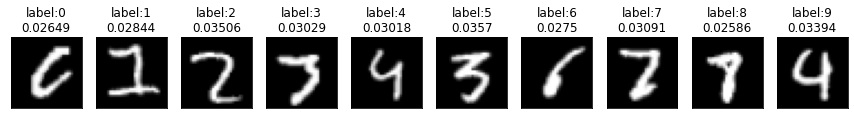

In [ ]:
fig, ax = plt.subplots(1,10,sharey=True, figsize=(15,5))
for i in range(10):
  x = np.argmax(np.max(arr, axis=0),axis=0)[i]
  y = i
  sample = argmax_array[x][y]
  print(x, y, sample)
  ax[i].imshow(X_train[sample].reshape((32,32)), cmap='gray')
  ax[i].title.set_text("label:" + str(np.argmax(y_train[sample])) + "\n" + str(np.max(np.max(arr, axis=0),axis=0)[i]))
  ax[i].set_xticks([])
  ax[i].set_yticks([])

5 0 494 label: 6
72 1 45143 label: 7
56 2 9788 label: 7
69 3 40144 label: 5
14 4 51248 label: 9
5 5 59719 label: 9
10 6 33626 label: 4
72 7 13082 label: 2
14 8 42854 label: 4
14 9 56970 label: 4


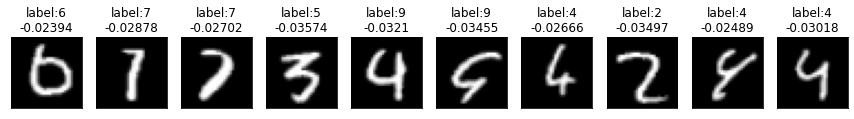

In [ ]:
fig, ax = plt.subplots(1,10,sharey=True, figsize=(15,5))
for i in range(10):
  x = np.argmin(np.min(arr, axis=0),axis=0)[i]
  y = i
  sample = argmin_array[x][y]
  print(x, y, sample, 'label:', np.argmax(y_train[sample]))
  ax[i].imshow(X_train[sample].reshape((32,32)), cmap='gray')
  ax[i].title.set_text("label:" + str(np.argmax(y_train[sample])) + "\n" + str(np.min(np.min(arr, axis=0),axis=0)[i]))
  ax[i].set_xticks([])
  ax[i].set_yticks([])

In [ ]:
print(argmax_array)

[[46412 29434 18003 39184 30792 40144  6474  5821 52932  1352]
 [50930 31727  8966 39184 11044 49890  8009 36760 47597 45352]
 [11501 55505  9396 50340 55340  1032 16590  9788 17244 29672]
 [19360 52854 49164 10042 15352 22779 49026  7010 19159 51248]
 [ 5298 37038 13508 41453 10736 59701   494  7010 47597 53216]
 [19360 52854 18003 52129 33626 57662   494 26882 39378 59719]
 [40240 52854 49070 51230 32499 17739 22212 17772 43109 29180]
 [11501 52854 13508 22204 56452  7270 46088 26560 39378 29672]
 [30123 16130  9396  8729 42854 15778 10044 47600 41396 14582]
 [59653 43897 13082  8729 32419 15402 46088 50371 11885 17551]
 [19360 52854 49164 13969 33626 57662  8898  7010 39378  9290]
 [47479 33752 49515 35401 15352 22779 26622  7010 42364 59719]
 [ 5298 29041 49573 50369 46314 31252 49139 50371 33388 51248]
 [57041 37816 37347 50369 24798 31252  3524 50371 19124 51248]
 [ 5298 37816 37347 48930 56970 15778 33242 47600 41396 51248]
 [ 1512 20672 27641 46269 15942 59701 49026 26560 47034

In [ ]:
resp_pos_labels = np.zeros((84,10))
for i in range(84):
  for j in range(10):
    resp_sample = argmax_array[i][j]
    resp_pos_labels[i][j] = np.argmax(y_train[resp_sample])


In [ ]:
resp_pos_labels

array([[0., 1., 2., 3., 4., 5., 6., 7., 8., 9.],
       [0., 1., 2., 3., 4., 5., 6., 7., 8., 9.],
       [0., 1., 2., 3., 4., 5., 6., 7., 8., 9.],
       [0., 1., 2., 3., 4., 5., 6., 7., 8., 9.],
       [0., 1., 2., 3., 4., 5., 6., 7., 8., 9.],
       [0., 1., 2., 3., 4., 5., 6., 7., 8., 9.],
       [0., 1., 2., 3., 4., 5., 6., 7., 8., 9.],
       [0., 1., 2., 3., 4., 5., 6., 7., 8., 9.],
       [0., 1., 2., 3., 4., 5., 6., 7., 8., 9.],
       [0., 1., 2., 3., 4., 5., 6., 7., 8., 9.],
       [0., 1., 2., 3., 4., 5., 6., 7., 8., 9.],
       [0., 1., 2., 3., 4., 5., 6., 7., 8., 9.],
       [0., 1., 2., 3., 4., 5., 6., 7., 8., 9.],
       [0., 1., 2., 3., 4., 5., 6., 7., 8., 9.],
       [0., 1., 2., 3., 4., 5., 6., 7., 8., 9.],
       [0., 1., 2., 3., 4., 5., 6., 7., 8., 9.],
       [0., 1., 2., 3., 4., 5., 6., 7., 8., 9.],
       [0., 1., 2., 3., 4., 5., 6., 7., 8., 9.],
       [0., 1., 2., 3., 4., 5., 6., 7., 8., 9.],
       [0., 1., 2., 3., 4., 5., 6., 7., 8., 9.],
       [0., 1., 2., 

In [ ]:
resp_neg_labels = np.zeros((84,10))
for i in range(84):
  for j in range(10):
    resp_sample = argmin_array[i][j]
    resp_neg_labels[i][j] = np.argmax(y_train[resp_sample])

In [ ]:
resp_neg_labels

array([[5., 7., 3., 5., 1., 3., 8., 3., 3., 7.],
       [8., 7., 7., 5., 9., 7., 0., 2., 5., 7.],
       [8., 2., 8., 2., 1., 3., 8., 8., 2., 8.],
       [6., 2., 6., 8., 6., 6., 4., 2., 6., 4.],
       [5., 0., 6., 5., 0., 0., 4., 2., 5., 0.],
       [6., 6., 5., 2., 0., 9., 5., 0., 6., 5.],
       [6., 6., 6., 5., 1., 6., 1., 1., 6., 1.],
       [8., 8., 1., 2., 8., 8., 1., 2., 1., 8.],
       [9., 4., 8., 9., 8., 9., 4., 3., 4., 7.],
       [7., 8., 8., 9., 8., 9., 8., 3., 9., 7.],
       [6., 6., 6., 6., 6., 6., 4., 0., 6., 4.],
       [6., 4., 6., 5., 9., 9., 4., 2., 6., 4.],
       [9., 8., 6., 9., 9., 9., 4., 9., 2., 7.],
       [9., 2., 4., 7., 9., 9., 4., 3., 2., 7.],
       [9., 4., 8., 9., 9., 9., 5., 9., 4., 4.],
       [1., 6., 6., 2., 6., 6., 1., 1., 1., 4.],
       [2., 7., 7., 7., 0., 9., 5., 2., 2., 4.],
       [9., 0., 4., 0., 9., 0., 4., 0., 6., 4.],
       [5., 3., 7., 5., 7., 3., 5., 3., 3., 5.],
       [9., 7., 7., 7., 7., 3., 2., 3., 9., 7.],
       [1., 7., 1., 

Most frequent positive responsible samples for predicting 0 :
       0  labels
5298  14       0
Most frequent positive responsible samples for predicting 1 :
        1  labels
52854  12       1
Most frequent positive responsible samples for predicting 2 :
       2  labels
9396  12       2
Most frequent positive responsible samples for predicting 3 :
       3  labels
39184  8       3
Most frequent positive responsible samples for predicting 4 :
        4  labels
59915  10       4
Most frequent positive responsible samples for predicting 5 :
       5  labels
26017  8       5
Most frequent positive responsible samples for predicting 6 :
       6  labels
22212  9       6
Most frequent positive responsible samples for predicting 7 :
       7  labels
7010  11       7
Most frequent positive responsible samples for predicting 8 :
        8  labels
39378  10       8
Most frequent positive responsible samples for predicting 9 :
       9  labels
14582  7       9


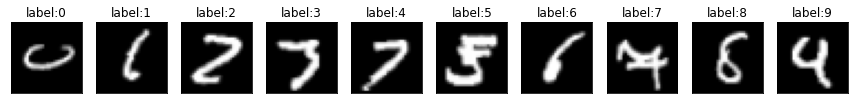

In [ ]:
df_pos_resp_samples = pd.DataFrame(argmax_array, columns=['0','1','2','3','4','5','6','7','8','9'])
fig, ax = plt.subplots(1,10,sharey=True, figsize=(15,5))
for i in range(10):
  print("Most frequent positive responsible samples for predicting", i, ":")
  most_frequent = df_pos_resp_samples[str(i)].value_counts().head(1)
  labels = []
  # fig, ax = plt.subplots(1,10,sharey=True, figsize=(15,5))
  # for j in range(10):
  sample = most_frequent.index[0]
  labels.append(np.argmax(y_train[sample]))
  ax[i].imshow(X_train[sample].reshape((32,32)), cmap='gray')
  ax[i].title.set_text("label:" + str(np.argmax(y_train[sample])))
  ax[i].set_xticks([])
  ax[i].set_yticks([])
  # plt.show()
  most_frequent = pd.DataFrame(most_frequent)
  most_frequent['labels'] = labels
  print(most_frequent)


Most frequent negative responsible samples for predicting 0 :
       0  labels
53216  9       9
Most frequent negative responsible samples for predicting 1 :
       1  labels
22212  7       6
Most frequent negative responsible samples for predicting 2 :
       2  labels
49026  9       6
Most frequent negative responsible samples for predicting 3 :
       3  labels
24570  6       2
Most frequent negative responsible samples for predicting 4 :
       4  labels
14582  8       9
Most frequent negative responsible samples for predicting 5 :
        5  labels
59719  10       9
Most frequent negative responsible samples for predicting 6 :
        6  labels
33626  10       4
Most frequent negative responsible samples for predicting 7 :
       7  labels
13082  9       2
Most frequent negative responsible samples for predicting 8 :
      8  labels
9396  9       2
Most frequent negative responsible samples for predicting 9 :
        9  labels
50371  11       7


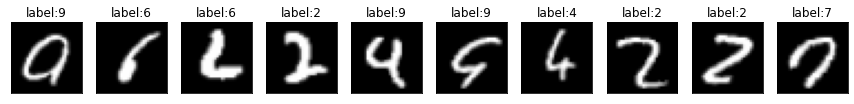

In [ ]:
df_neg_resp_samples = pd.DataFrame(argmin_array, columns=['0','1','2','3','4','5','6','7','8','9'])
fig, ax = plt.subplots(1,10,sharey=True, figsize=(15,5))
for i in range(10):
  print("Most frequent negative responsible samples for predicting", i, ":")
  most_frequent = df_neg_resp_samples[str(i)].value_counts().head(1)
  labels = []
  # fig, ax = plt.subplots(1,10,sharey=True, figsize=(15,5))
  # for j in range(10):
  sample = most_frequent.index[0]
  labels.append(np.argmax(y_train[sample]))
  ax[i].imshow(X_train[sample].reshape((32,32)), cmap='gray')
  ax[i].title.set_text(str(np.argmax(y_train[sample])))
  ax[i].title.set_text("label:" + str(np.argmax(y_train[sample])))
  ax[i].set_xticks([])
  ax[i].set_yticks([])
  # plt.show()
  most_frequent = pd.DataFrame(most_frequent)
  most_frequent['labels'] = labels
  print(most_frequent)

Most frequent positive responsible samples for predicting 0 :


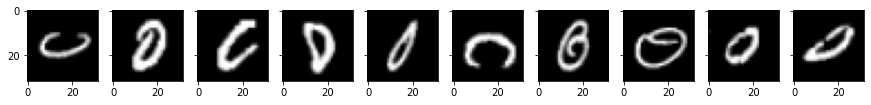

        0  labels
5298   14       0
11501   8       0
19360   8       0
56914   6       0
40240   4       0
50930   4       0
57486   3       0
17466   3       0
57041   3       0
47479   2       0
Most frequent positive responsible samples for predicting 1 :


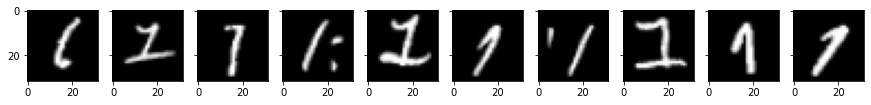

        1  labels
52854  12       1
37038   9       1
16130   6       1
43897   5       1
20672   5       1
29041   4       1
31727   4       1
29434   4       1
37816   3       1
23911   3       1
Most frequent positive responsible samples for predicting 2 :


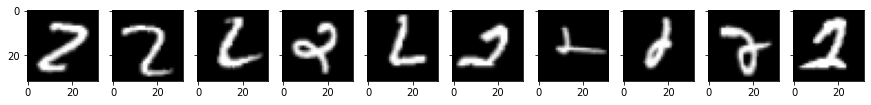

        2  labels
9396   12       2
13082  11       2
13508   6       2
37347   6       2
49164   5       2
18003   5       2
15434   4       2
7732    3       2
45868   2       2
27641   2       2
Most frequent positive responsible samples for predicting 3 :


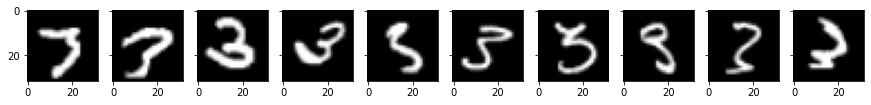

       3  labels
39184  8       3
8729   7       3
10042  5       3
13969  5       3
40752  4       3
25829  4       3
21948  3       3
58064  3       3
20016  3       3
44456  3       3
Most frequent positive responsible samples for predicting 4 :


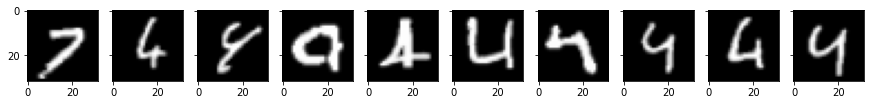

        4  labels
59915  10       4
33626   9       4
42854   7       4
24798   6       4
15942   6       4
10736   5       4
11044   4       4
56970   4       4
15352   3       4
41680   2       4
Most frequent positive responsible samples for predicting 5 :


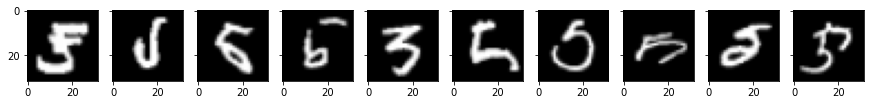

       5  labels
26017  8       5
59701  6       5
15778  5       5
57662  5       5
40144  5       5
51764  4       5
6848   4       5
38408  3       5
635    3       5
31252  3       5
Most frequent positive responsible samples for predicting 6 :


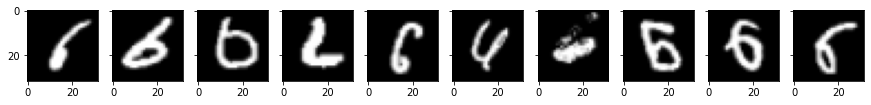

       6  labels
22212  9       6
6474   7       6
494    7       6
49026  6       6
46088  6       6
35616  6       6
49139  4       6
41538  4       6
57764  3       6
8898   3       6
Most frequent positive responsible samples for predicting 7 :


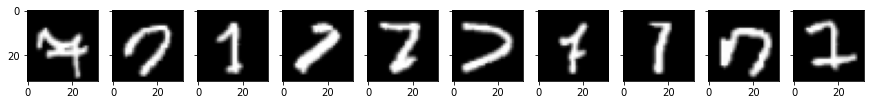

        7  labels
7010   11       7
50371   6       7
26560   5       7
44378   5       7
52899   5       7
20226   5       7
15276   4       7
45143   4       7
26882   4       7
2676    4       7
Most frequent positive responsible samples for predicting 8 :


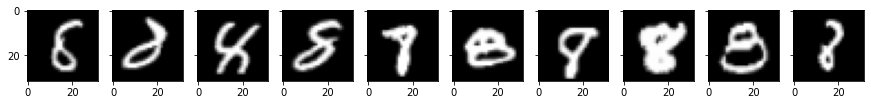

        8  labels
39378  10       8
52932   8       8
41396   6       8
30525   5       8
5896    5       8
47597   4       8
11885   4       8
756     3       8
27085   3       8
12936   2       8
Most frequent positive responsible samples for predicting 9 :


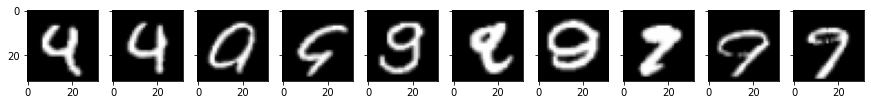

       9  labels
14582  7       9
51248  7       9
53216  6       9
59719  5       9
49656  5       9
34404  5       9
18598  5       9
39423  4       9
17551  4       9
50329  3       9


In [ ]:
df_pos_resp_samples = pd.DataFrame(argmax_array, columns=['0','1','2','3','4','5','6','7','8','9'])
for i in range(10):
  print("Most frequent positive responsible samples for predicting", i, ":")
  most_frequent = df_pos_resp_samples[str(i)].value_counts().head(10)
  labels = []
  fig, ax = plt.subplots(1,10,sharey=True, figsize=(15,5))
  for j in range(10):
    sample = most_frequent.index[j]
    labels.append(np.argmax(y_train[sample]))
    ax[j].imshow(X_train[sample].reshape((32,32)), cmap='gray')
  plt.show()
  most_frequent = pd.DataFrame(most_frequent)
  most_frequent['labels'] = labels
  print(most_frequent)

Most frequent negative responsible samples for predicting 0 :


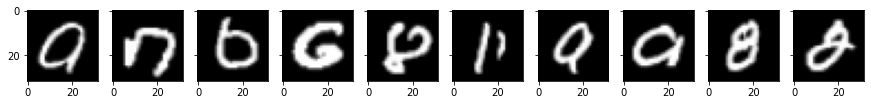

       0  labels
53216  9       9
26882  5       7
494    4       6
3524   4       6
7851   4       8
21601  4       1
39942  3       9
50239  3       9
58384  3       8
59720  3       2
Most frequent negative responsible samples for predicting 1 :


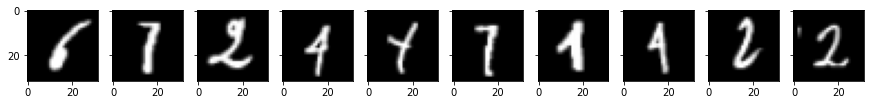

       1  labels
22212  7       6
45143  7       7
37120  4       2
37648  4       4
17091  4       4
25308  4       7
54264  4       4
29206  3       4
17763  3       2
46115  2       2
Most frequent negative responsible samples for predicting 2 :


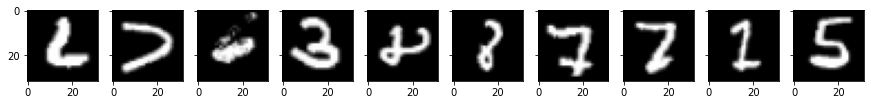

       2  labels
49026  9       6
20226  7       7
49139  5       6
10042  5       3
24587  4       8
12936  3       8
31844  3       7
52899  3       7
7898   3       1
2209   2       5
Most frequent negative responsible samples for predicting 3 :


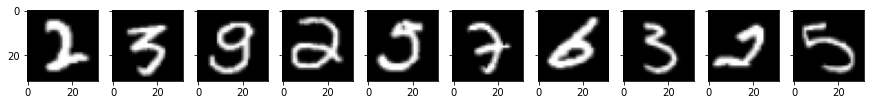

       3  labels
24570  6       2
40144  6       5
49656  5       9
2748   5       2
19089  4       5
31850  3       7
6474   3       6
43454  3       5
18003  3       2
38932  3       5
Most frequent negative responsible samples for predicting 4 :


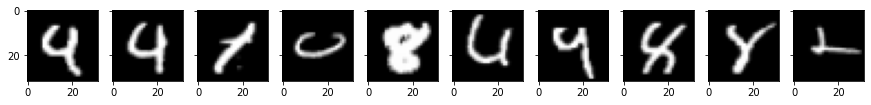

       4  labels
14582  8       9
51248  8       9
17213  6       1
5298   5       0
756    4       8
26622  3       6
28422  3       9
41396  3       8
42112  3       8
15434  2       2
Most frequent negative responsible samples for predicting 5 :


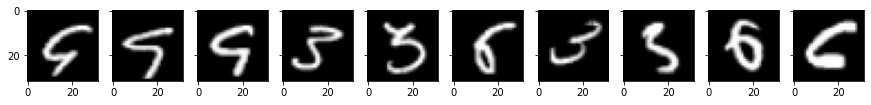

        5  labels
59719  10       9
30049   6       9
24497   5       9
25829   5       3
21948   5       3
8898    4       6
52129   4       3
40752   4       3
57764   3       6
48649   2       6
Most frequent negative responsible samples for predicting 6 :


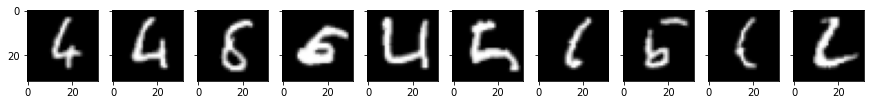

        6  labels
33626  10       4
15352   7       4
39378   7       8
22779   5       5
10736   5       4
51764   4       5
52854   4       1
57662   3       5
21944   3       1
13508   3       2
Most frequent negative responsible samples for predicting 7 :


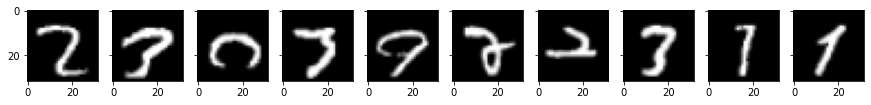

       7  labels
13082  9       2
8729   6       3
50930  6       0
39184  5       3
17551  5       9
45868  4       2
44898  3       2
2098   3       3
16130  3       1
20746  2       1
Most frequent negative responsible samples for predicting 8 :


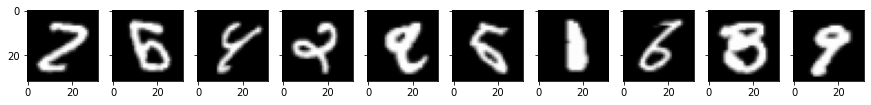

       8  labels
9396   9       2
41538  6       6
42854  6       4
37347  6       2
34404  4       9
15778  4       5
56717  4       1
36363  3       6
47689  2       3
51239  2       9
Most frequent negative responsible samples for predicting 9 :


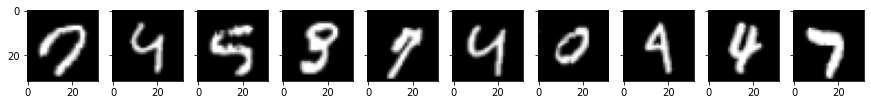

        9  labels
50371  11       7
56970   7       4
24660   6       5
50417   6       3
5821    5       7
41680   4       4
57041   3       0
32112   2       4
2578    2       4
28399   2       7


In [ ]:
df_neg_resp_samples = pd.DataFrame(argmin_array, columns=['0','1','2','3','4','5','6','7','8','9'])
for i in range(10):
  print("Most frequent negative responsible samples for predicting", i, ":")
  most_frequent = df_neg_resp_samples[str(i)].value_counts().head(10)
  labels = []
  fig, ax = plt.subplots(1,10,sharey=True, figsize=(15,5))
  for j in range(10):
    sample = most_frequent.index[j]
    labels.append(np.argmax(y_train[sample]))
    ax[j].imshow(X_train[sample].reshape((32,32)), cmap='gray')
  plt.show()
  most_frequent = pd.DataFrame(most_frequent)
  most_frequent['labels'] = labels
  print(most_frequent)

In [ ]:
arr.shape

(60000, 84, 10)

In [ ]:
np.mean(arr, dtype=np.float64)

6.839242719468616e-10

In [ ]:
np.std(arr, dtype=np.float64)

0.00033625402408842426

In [ ]:
np.mean(np.sum(arr,axis=(1,2)),dtype=np.float64)

5.744963884353638e-07

In [ ]:
np.std(np.sum(arr,axis=(1,2)),dtype=np.float64)

2.159334350465368e-06

In [ ]:
contributions = np.zeros((10,10))
for ind in range(len(arr)):
  label = np.argmax(y_train[ind])
  changes = arr[ind]
  contribution = np.sum(changes,axis=0,dtype=np.float64)
  contributions[label] += contribution


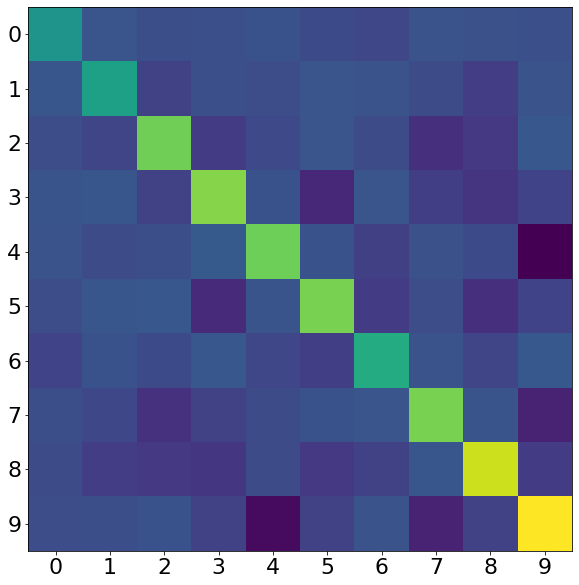

In [ ]:
plt.rcParams.update({'font.size': 22})
fig, ax = plt.subplots(figsize=(10,10))
plt.setp(ax, xticks=range(10), yticks=range(10))
ax.imshow(contributions)
plt.show()

# Experiment for demonstrating different sets of responsible instances:

In [ ]:
model = build_model(num_classes=10, input_shape=[32,32,1], model_type='lenet_5')
model.load_weights('/content/drive/MyDrive/Hydra_IF_Responsibility/model_2.h5')
model.compile(loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
total_delta_weights = pickle.load(open("/content/drive/MyDrive/Hydra_IF_Responsibility/total_delta_weights_2.pickle", "rb"))

In [ ]:
arr = np.array(total_delta_weights, dtype=np.float16)
argmax_array = np.argmax(arr, axis=0)
argmin_array = np.argmin(arr, axis=0)

Most frequent positive responsible samples for predicting 0 :
        0  labels
51464  10       0
Most frequent positive responsible samples for predicting 1 :
       1  labels
37038  7       1
Most frequent positive responsible samples for predicting 2 :
        2  labels
13508  10       2
Most frequent positive responsible samples for predicting 3 :
      3  labels
8729  9       3
Most frequent positive responsible samples for predicting 4 :
        4  labels
59915  10       4
Most frequent positive responsible samples for predicting 5 :
        5  labels
40144  10       5
Most frequent positive responsible samples for predicting 6 :
       6  labels
49026  9       6
Most frequent positive responsible samples for predicting 7 :
        7  labels
26882  10       7
Most frequent positive responsible samples for predicting 8 :
       8  labels
11885  6       8
Most frequent positive responsible samples for predicting 9 :
       9  labels
50239  6       9


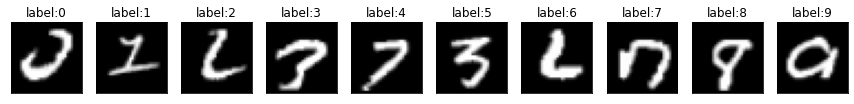

In [ ]:
df_pos_resp_samples = pd.DataFrame(argmax_array, columns=['0','1','2','3','4','5','6','7','8','9'])
fig, ax = plt.subplots(1,10,sharey=True, figsize=(15,5))
for i in range(10):
  print("Most frequent positive responsible samples for predicting", i, ":")
  most_frequent = df_pos_resp_samples[str(i)].value_counts().head(1)
  labels = []
  # fig, ax = plt.subplots(1,10,sharey=True, figsize=(15,5))
  # for j in range(10):
  sample = most_frequent.index[0]
  labels.append(np.argmax(y_train[sample]))
  ax[i].imshow(X_train[sample].reshape((32,32)), cmap='gray')
  ax[i].title.set_text("label:" + str(np.argmax(y_train[sample])))
  ax[i].set_xticks([])
  ax[i].set_yticks([])
  # plt.show()
  most_frequent = pd.DataFrame(most_frequent)
  most_frequent['labels'] = labels
  print(most_frequent)

Most frequent negative responsible samples for predicting 0 :
        0  labels
26882  10       7
Most frequent negative responsible samples for predicting 1 :
       1  labels
29206  9       4
Most frequent negative responsible samples for predicting 2 :
       2  labels
9788  10       7
Most frequent negative responsible samples for predicting 3 :
        3  labels
31016  12       2
Most frequent negative responsible samples for predicting 4 :
        4  labels
51248  10       9
Most frequent negative responsible samples for predicting 5 :
       5  labels
59719  8       9
Most frequent negative responsible samples for predicting 6 :
       6  labels
51764  9       5
Most frequent negative responsible samples for predicting 7 :
       7  labels
17220  8       2
Most frequent negative responsible samples for predicting 8 :
      8  labels
9396  8       2
Most frequent negative responsible samples for predicting 9 :
        9  labels
50371  10       7


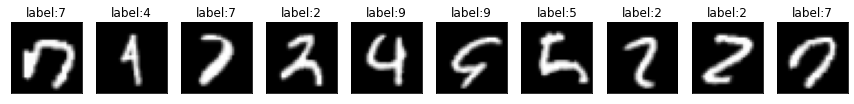

In [ ]:
df_neg_resp_samples = pd.DataFrame(argmin_array, columns=['0','1','2','3','4','5','6','7','8','9'])
fig, ax = plt.subplots(1,10,sharey=True, figsize=(15,5))
for i in range(10):
  print("Most frequent negative responsible samples for predicting", i, ":")
  most_frequent = df_neg_resp_samples[str(i)].value_counts().head(1)
  labels = []
  # fig, ax = plt.subplots(1,10,sharey=True, figsize=(15,5))
  # for j in range(10):
  sample = most_frequent.index[0]
  labels.append(np.argmax(y_train[sample]))
  ax[i].imshow(X_train[sample].reshape((32,32)), cmap='gray')
  ax[i].title.set_text(str(np.argmax(y_train[sample])))
  ax[i].title.set_text("label:" + str(np.argmax(y_train[sample])))
  ax[i].set_xticks([])
  ax[i].set_yticks([])
  # plt.show()
  most_frequent = pd.DataFrame(most_frequent)
  most_frequent['labels'] = labels
  print(most_frequent)

77 0 5298
11 1 4502
75 2 9396
61 3 57457
77 4 33626
61 5 40144
52 6 1784
11 7 9788
52 8 39378
61 9 56199


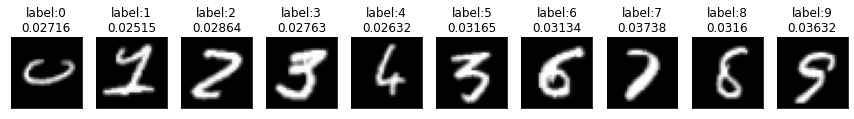

In [ ]:
fig, ax = plt.subplots(1,10,sharey=True, figsize=(15,5))
for i in range(10):
  x = np.argmax(np.max(arr, axis=0),axis=0)[i]
  y = i
  sample = argmax_array[x][y]
  print(x, y, sample)
  ax[i].imshow(X_train[sample].reshape((32,32)), cmap='gray')
  ax[i].title.set_text("label:" + str(np.argmax(y_train[sample])) + "\n" + str(np.max(np.max(arr, axis=0),axis=0)[i]))
  ax[i].set_xticks([])
  ax[i].set_yticks([])

35 0 24798 label: 4
52 1 22212 label: 6
11 2 9788 label: 7
61 3 40144 label: 5
45 4 51248 label: 9
61 5 56199 label: 9
52 6 39378 label: 8
65 7 17551 label: 9
52 8 22561 label: 6
45 9 51350 label: 4


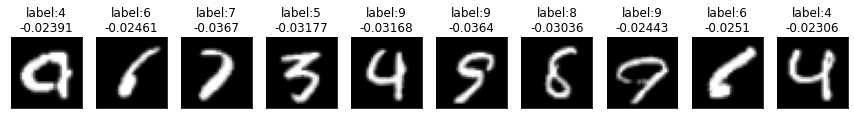

In [ ]:
fig, ax = plt.subplots(1,10,sharey=True, figsize=(15,5))
for i in range(10):
  x = np.argmin(np.min(arr, axis=0),axis=0)[i]
  y = i
  sample = argmin_array[x][y]
  print(x, y, sample, 'label:', np.argmax(y_train[sample]))
  ax[i].imshow(X_train[sample].reshape((32,32)), cmap='gray')
  ax[i].title.set_text("label:" + str(np.argmax(y_train[sample])) + "\n" + str(np.min(np.min(arr, axis=0),axis=0)[i]))
  ax[i].set_xticks([])
  ax[i].set_yticks([])

In [ ]:
model = build_model(num_classes=10, input_shape=[32,32,1], model_type='lenet_5')
model.load_weights('/content/drive/MyDrive/Hydra_IF_Responsibility/model_3.h5')
model.compile(loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
total_delta_weights = pickle.load(open("/content/drive/MyDrive/Hydra_IF_Responsibility/total_delta_weights_3.pickle", "rb"))

In [ ]:
arr = np.array(total_delta_weights, dtype=np.float16)
argmax_array = np.argmax(arr, axis=0)
argmin_array = np.argmin(arr, axis=0)

Most frequent positive responsible samples for predicting 0 :
       0  labels
5298  13       0
Most frequent positive responsible samples for predicting 1 :
        1  labels
52854  10       1
Most frequent positive responsible samples for predicting 2 :
        2  labels
15434  11       2
Most frequent positive responsible samples for predicting 3 :
       3  labels
20016  6       3
Most frequent positive responsible samples for predicting 4 :
        4  labels
42854  12       4
Most frequent positive responsible samples for predicting 5 :
        5  labels
59701  11       5
Most frequent positive responsible samples for predicting 6 :
       6  labels
49026  9       6
Most frequent positive responsible samples for predicting 7 :
        7  labels
45615  11       7
Most frequent positive responsible samples for predicting 8 :
       8  labels
42112  9       8
Most frequent positive responsible samples for predicting 9 :
       9  labels
51248  8       9


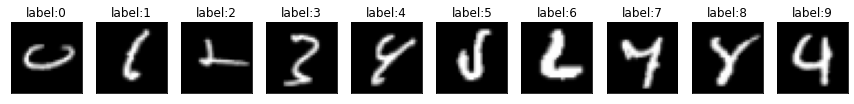

In [ ]:
df_pos_resp_samples = pd.DataFrame(argmax_array, columns=['0','1','2','3','4','5','6','7','8','9'])
fig, ax = plt.subplots(1,10,sharey=True, figsize=(15,5))
for i in range(10):
  print("Most frequent positive responsible samples for predicting", i, ":")
  most_frequent = df_pos_resp_samples[str(i)].value_counts().head(1)
  labels = []
  # fig, ax = plt.subplots(1,10,sharey=True, figsize=(15,5))
  # for j in range(10):
  sample = most_frequent.index[0]
  labels.append(np.argmax(y_train[sample]))
  ax[i].imshow(X_train[sample].reshape((32,32)), cmap='gray')
  ax[i].title.set_text("label:" + str(np.argmax(y_train[sample])))
  ax[i].set_xticks([])
  ax[i].set_yticks([])
  # plt.show()
  most_frequent = pd.DataFrame(most_frequent)
  most_frequent['labels'] = labels
  print(most_frequent)

Most frequent negative responsible samples for predicting 0 :
       0  labels
50239  7       9
Most frequent negative responsible samples for predicting 1 :
        1  labels
22212  13       6
Most frequent negative responsible samples for predicting 2 :
       2  labels
49026  9       6
Most frequent negative responsible samples for predicting 3 :
       3  labels
12286  7       2
Most frequent negative responsible samples for predicting 4 :
       4  labels
51248  9       9
Most frequent negative responsible samples for predicting 5 :
        5  labels
30049  11       9
Most frequent negative responsible samples for predicting 6 :
       6  labels
33626  7       4
Most frequent negative responsible samples for predicting 7 :
       7  labels
30792  8       4
Most frequent negative responsible samples for predicting 8 :
        8  labels
42854  10       4
Most frequent negative responsible samples for predicting 9 :
       9  labels
50371  9       7


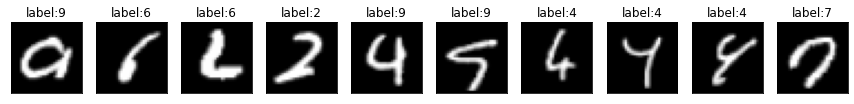

In [ ]:
df_neg_resp_samples = pd.DataFrame(argmin_array, columns=['0','1','2','3','4','5','6','7','8','9'])
fig, ax = plt.subplots(1,10,sharey=True, figsize=(15,5))
for i in range(10):
  print("Most frequent negative responsible samples for predicting", i, ":")
  most_frequent = df_neg_resp_samples[str(i)].value_counts().head(1)
  labels = []
  # fig, ax = plt.subplots(1,10,sharey=True, figsize=(15,5))
  # for j in range(10):
  sample = most_frequent.index[0]
  labels.append(np.argmax(y_train[sample]))
  ax[i].imshow(X_train[sample].reshape((32,32)), cmap='gray')
  ax[i].title.set_text(str(np.argmax(y_train[sample])))
  ax[i].title.set_text("label:" + str(np.argmax(y_train[sample])))
  ax[i].set_xticks([])
  ax[i].set_yticks([])
  # plt.show()
  most_frequent = pd.DataFrame(most_frequent)
  most_frequent['labels'] = labels
  print(most_frequent)

35 0 19360
20 1 29434
49 2 9396
49 3 33009
60 4 30792
18 5 40144
68 6 5554
20 7 2676
49 8 12936
59 9 51248


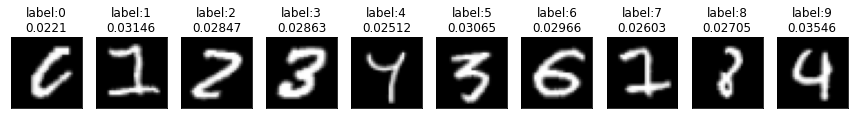

In [ ]:
fig, ax = plt.subplots(1,10,sharey=True, figsize=(15,5))
for i in range(10):
  x = np.argmax(np.max(arr, axis=0),axis=0)[i]
  y = i
  sample = argmax_array[x][y]
  print(x, y, sample)
  ax[i].imshow(X_train[sample].reshape((32,32)), cmap='gray')
  ax[i].title.set_text("label:" + str(np.argmax(y_train[sample])) + "\n" + str(np.max(np.max(arr, axis=0),axis=0)[i]))
  ax[i].set_xticks([])
  ax[i].set_yticks([])

5 0 50239 label: 9
38 1 22212 label: 6
20 2 29434 label: 1
18 3 40144 label: 5
59 4 51248 label: 9
68 5 30049 label: 9
68 6 57662 label: 5
18 7 2098 label: 3
58 8 42854 label: 4
64 9 41680 label: 4


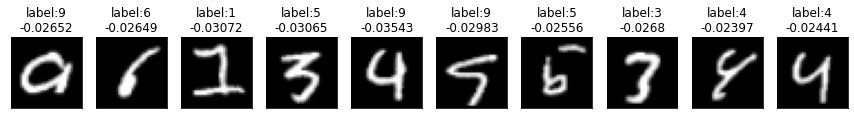

In [ ]:
fig, ax = plt.subplots(1,10,sharey=True, figsize=(15,5))
for i in range(10):
  x = np.argmin(np.min(arr, axis=0),axis=0)[i]
  y = i
  sample = argmin_array[x][y]
  print(x, y, sample, 'label:', np.argmax(y_train[sample]))
  ax[i].imshow(X_train[sample].reshape((32,32)), cmap='gray')
  ax[i].title.set_text("label:" + str(np.argmax(y_train[sample])) + "\n" + str(np.min(np.min(arr, axis=0),axis=0)[i]))
  ax[i].set_xticks([])
  ax[i].set_yticks([])